# Weather Data Comparison

## Data Loading

In [85]:
from pathlib import Path

import pandas as pd

import matplotlib.pyplot as plt

# Root directory for datasets
DATASETS_ROOT = '../datasets/data-1'

# Set dark mode style for all plots
plt.style.use('dark_background')


def load_pvoutput_data(file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df['time'] = pd.to_datetime(df['date'].astype(str) + 'T' + df['time'])
    df = df[['time', 'power', 'average', 'temperature']]
    # df = df.set_index('datetime').resample('15T').mean().reset_index()
    return df


def load_openmeteo_hourly_data(file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df['time'] = pd.to_datetime(df['time'])
    # df = df[[
    #     'time',
    #     # 'direct_radiation_satellite_radiation_seamless',
    #     'direct_normal_irradiance_satellite_radiation_seamless',
    #     'diffuse_radiation_satellite_radiation_seamless',
    #     'diffuse_radiation_instant_satellite_radiation_seamless',
    #     'direct_normal_irradiance_instant_satellite_radiation_seamless',
    #     # 'direct_radiation_instant_satellite_radiation_seamless',
    #
    #     # 'direct_radiation_archive_best_match',
    #     'direct_normal_irradiance_archive_best_match',
    #     'diffuse_radiation_archive_best_match',
    #     'diffuse_radiation_instant_archive_best_match',
    #     'direct_normal_irradiance_instant_archive_best_match',
    #     # 'direct_radiation_instant_archive_best_match',
    #
    #     # 'direct_radiation',
    #     'direct_normal_irradiance',
    #     'diffuse_radiation',
    #     'diffuse_radiation_instant',
    #     'direct_normal_irradiance_instant',
    #     # 'direct_radiation_instant'
    # ]]
    return df


def load_openmeteo_quarterhourly_data(file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df['time'] = pd.to_datetime(df['time'])
    df = df[[
        'time',
        # 'temperature_2m',
        'visibility',
        'cloud_cover',
        # 'cloud_cover_low',
        # 'cloud_cover_mid',
        # 'cloud_cover_high',
        'direct_radiation',
        'direct_normal_irradiance',
        'diffuse_radiation',
        'diffuse_radiation_instant',
        'direct_normal_irradiance_instant',
        'direct_radiation_instant']]
    return df


def load_visualcrossing_hourly_data(file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df['time'] = pd.to_datetime(df['datetime'])
    df = df[[
        'time',
        # 'temp',
        # 'humidity',
        # 'precip',
        # 'preciptype',
        # 'precipremote',
        # 'windspeed',
        # 'winddir',
        # 'sealevelpressure',
        'cloudcover',
        'visibility',
        'solarradiation'
    ]]
    return df


def load_visualcrossing_quarterhourly_data(file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df['time'] = pd.to_datetime(df['datetime'])
    df = df[[
        'time',
        # 'temp',
        # 'humidity',
        # 'precip',
        # 'preciptype',
        # 'precipremote',
        # 'windspeed',
        # 'winddir',
        # 'sealevelpressure',
        'cloudcover',
        'visibility',
        'solarradiation'
    ]]
    return df


def plot_time_window(df, start_time=None, end_time=None):
    if start_time is not None:
        start_time = pd.to_datetime(start_time)
    if end_time is not None:
        end_time = pd.to_datetime(end_time)
    mask = pd.Series([True] * len(df))
    if start_time is not None:
        mask &= df['time'] >= start_time
    if end_time is not None:
        mask &= df['time'] <= end_time
    plt.figure(figsize=(14, 7))
    # Define which columns to plot with symbols
    symbol_cols = [
        'direct_normal_irradiance',
        'direct_normal_irradiance_instant',
        'diffuse_radiation',
        'diffuse_radiation_instant'
    ]
    # Plot all columns
    for col in df.columns:
        if col == 'time':
            continue
        if col in symbol_cols and col in df:
            plt.plot(df.loc[mask, 'time'], df.loc[mask, col], marker='o', linestyle='', label=col)
        else:
            plt.plot(df.loc[mask, 'time'], df.loc[mask, col], label=col)
    plt.xlabel('Time')
    plt.ylabel('Value')
    title = 'OpenMeteo Quarterhourly Data - All Fields'
    if start_time is not None and end_time is not None:
        title += f' ({start_time.date()} to {end_time.date()})'
    elif start_time is not None:
        title += f' (from {start_time.date()})'
    elif end_time is not None:
        title += f' (until {end_time.date()})'
    plt.title(title)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


pvo = load_pvoutput_data(Path(f'{DATASETS_ROOT}/pvoutput_89665.csv'))

om_hourly = load_openmeteo_hourly_data(Path(f'{DATASETS_ROOT}/openmeteo-hourly_89665.csv'))
om_qhourly = load_openmeteo_quarterhourly_data(Path(f'{DATASETS_ROOT}/openmeteo-quarterhourly_89665.csv'))

vc_hourly = load_visualcrossing_hourly_data(Path(f'{DATASETS_ROOT}/visualcrossing-hourly_89665.csv'))
vc_qhourly = load_visualcrossing_quarterhourly_data(Path(f'{DATASETS_ROOT}/visualcrossing-quarterhourly_89665.csv'))


Initial processing

In [86]:
def normalise_column(target: pd.Series):
    """
    Normalise a column by the maximum value of the field in the reference dataset and scale to 100.
    Returns a pandas Series of the normalised values.
    """
    max_value = target.max()
    if max_value == 0:
        return target * 0
    return (target / max_value) * 100

for df in [om_hourly, om_qhourly, vc_hourly, vc_qhourly]:
    if 'visibility' in df.columns:
        df['visibility_normalised'] = normalise_column(df['visibility'])


## Inspection

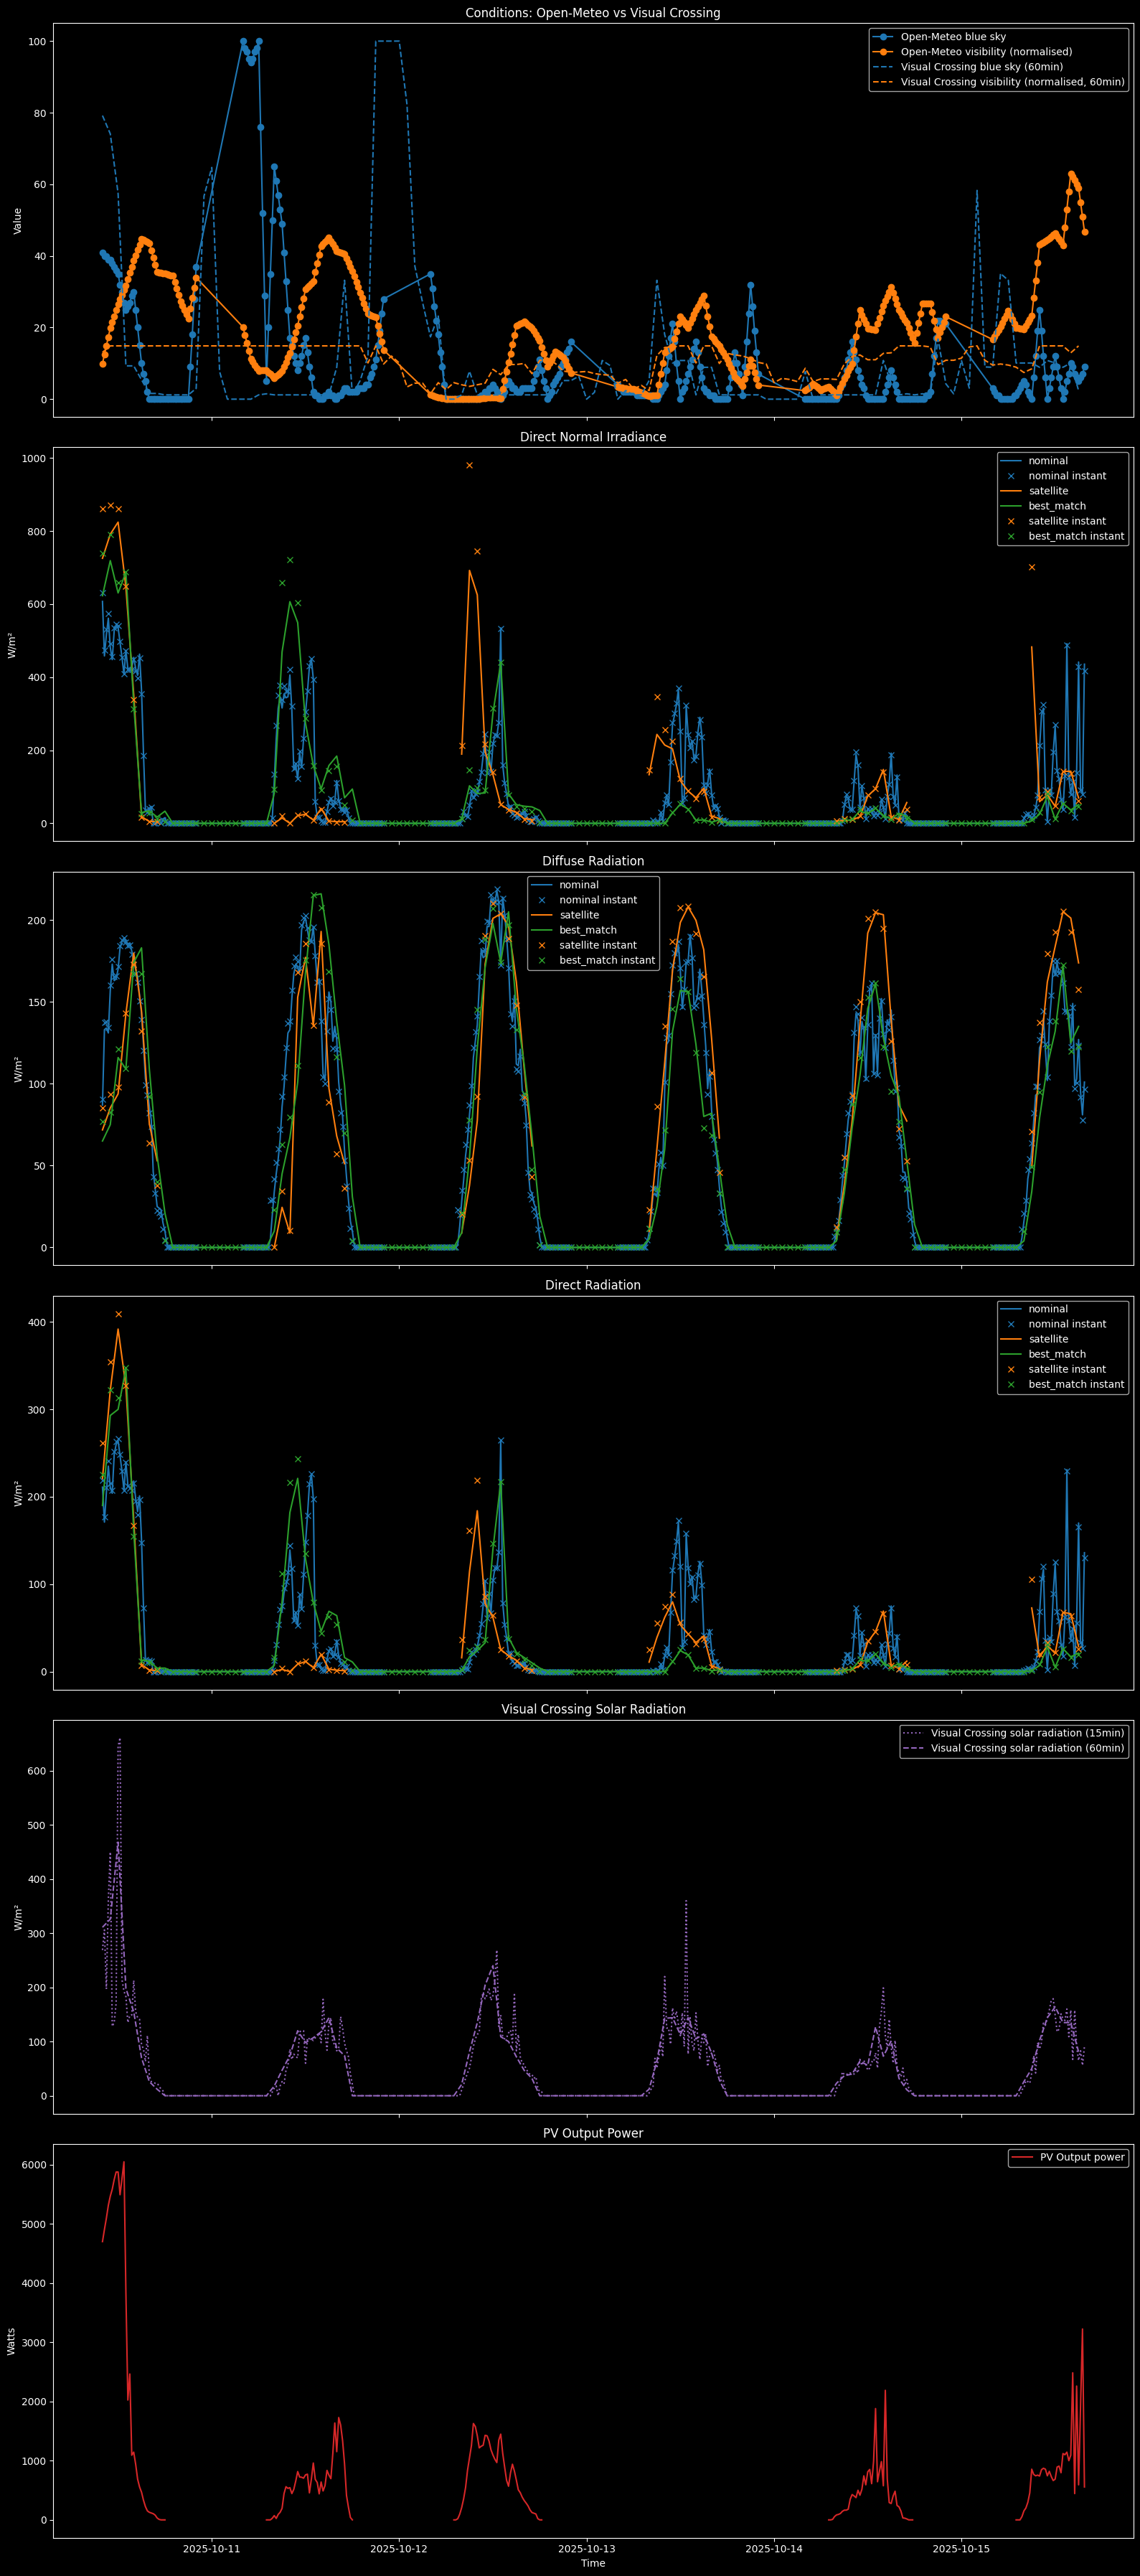

In [87]:
from typing import Optional

start = pd.Timestamp('2025-10-10 10:00:00')
end = pd.Timestamp('2025-10-15 16:00:00')

om_hourly_slice = om_hourly[(om_hourly['time'] >= start) & (om_hourly['time'] < end)]
om_qhourly_slice = om_qhourly[(om_qhourly['time'] >= start) & (om_qhourly['time'] < end)]

# Slice Visual Crossing data to the same time window
vc_hourly_slice = vc_hourly[(vc_hourly['time'] >= start) & (vc_hourly['time'] < end)].copy()
vc_qhourly_slice = vc_qhourly[(vc_qhourly['time'] >= start) & (vc_qhourly['time'] < end)].copy()

# Slice PV Output data to the same time window
pvo_slice = pvo[(pvo['time'] >= start) & (pvo['time'] < end)].copy()

# Compute blue_sky and visibility_normalised for Visual Crossing
vc_qhourly_slice['blue_sky'] = 100 - vc_qhourly_slice['cloudcover']
vc_hourly_slice['blue_sky'] = 100 - vc_hourly_slice['cloudcover']

# Six charts from the combined dataset, all with time on the x-axis
fig, axes = plt.subplots(6, 1, figsize=(16, 36), sharex=True)

# Define color mapping for each group to ensure marker and line colors match
color_map = {
    'nominal': 'tab:blue',
    'satellite': 'tab:orange',
    'best_match': 'tab:green',
    'nominal instant': 'tab:blue',
    'satellite instant': 'tab:orange',
    'best_match instant': 'tab:green',
}

# 1. Conditions - with Visual Crossing comparison
if 'cloud_cover' in om_qhourly_slice.columns:
    blue_sky = 100 - om_qhourly_slice['cloud_cover']
    axes[0].plot(om_qhourly_slice['time'], blue_sky, label='Open-Meteo blue sky', color='tab:blue', linestyle='-', marker='o')
if 'visibility_normalised' in om_qhourly_slice.columns:
    axes[0].plot(om_qhourly_slice['time'], om_qhourly_slice['visibility_normalised'], label='Open-Meteo visibility (normalised)', color='tab:orange', linestyle='-', marker='o')

# Add Visual Crossing data with dashed and dotted lines
# axes[0].plot(vc_quarterhourly_slice['time'], vc_quarterhourly_slice['blue_sky'], label='Visual Crossing blue sky (15min)', color='tab:blue', linestyle=':')
axes[0].plot(vc_hourly_slice['time'], vc_hourly_slice['blue_sky'], label='Visual Crossing blue sky (60min)', color='tab:blue', linestyle='--')
# axes[0].plot(vc_quarterhourly_slice['time'], vc_quarterhourly_slice['visibility_normalised'], label='Visual Crossing visibility (normalised, 15min)', color='tab:orange', linestyle=':')
axes[0].plot(vc_hourly_slice['time'], vc_hourly_slice['visibility_normalised'], label='Visual Crossing visibility (normalised, 60min)', color='tab:orange', linestyle='--')

axes[0].set_title('Conditions: Open-Meteo vs Visual Crossing')
axes[0].set_ylabel('Value')
axes[0].legend()

# 2. Direct Normal Irradiance
# Generalized plotting function for Open-Meteo fields

def plot_om_fields(ax, df, fields, color_map):
    for field, label, style in fields:
        if field in df.columns:
            color = color_map.get(label, None)
            if 'instant' in field:
                ax.plot(df['time'], df[field], marker=style, linestyle='', label=label, color=color)
            else:
                ax.plot(df['time'], df[field], label=label, color=color)

plot_om_fields(
    axes[1], om_qhourly_slice,
    [
        ('direct_normal_irradiance', 'nominal', '-'),
        ('direct_normal_irradiance_instant', 'nominal instant', 'x'),
    ], color_map
)
plot_om_fields(
    axes[1], om_hourly_slice,
    [
        ('direct_normal_irradiance_satellite_radiation_seamless', 'satellite', '-'),
        ('direct_normal_irradiance_archive_best_match', 'best_match', '-'),
        ('direct_normal_irradiance_instant_satellite_radiation_seamless', 'satellite instant', 'x'),
        ('direct_normal_irradiance_instant_archive_best_match', 'best_match instant', 'x'),
    ], color_map
)
axes[1].set_title('Direct Normal Irradiance')
axes[1].set_ylabel('W/m²')
axes[1].legend()

# 3. Diffuse Radiation
plot_om_fields(
    axes[2], om_qhourly_slice,
    [
        ('diffuse_radiation', 'nominal', '-'),
        ('diffuse_radiation_instant', 'nominal instant', 'x'),
    ], color_map
)
plot_om_fields(
    axes[2], om_hourly_slice,
    [
        ('diffuse_radiation_satellite_radiation_seamless', 'satellite', '-'),
        ('diffuse_radiation_archive_best_match', 'best_match', '-'),
        ('diffuse_radiation_instant_satellite_radiation_seamless', 'satellite instant', 'x'),
        ('diffuse_radiation_instant_archive_best_match', 'best_match instant', 'x'),
    ], color_map
)
axes[2].set_title('Diffuse Radiation')
axes[2].set_ylabel('W/m²')
axes[2].legend()

# 4. Direct Radiation
plot_om_fields(
    axes[3], om_qhourly_slice,
    [
        ('direct_radiation', 'nominal', '-'),
        ('direct_radiation_instant', 'nominal instant', 'x'),
    ], color_map
)
plot_om_fields(
    axes[3], om_hourly_slice,
    [
        ('direct_radiation_satellite_radiation_seamless', 'satellite', '-'),
        ('direct_radiation_archive_best_match', 'best_match', '-'),
        ('direct_radiation_instant_satellite_radiation_seamless', 'satellite instant', 'x'),
        ('direct_radiation_instant_archive_best_match', 'best_match instant', 'x'),
    ], color_map
)
axes[3].set_title('Direct Radiation')
axes[3].set_ylabel('W/m²')
axes[3].legend()

# 5. Visual Crossing Solar Radiation
axes[4].plot(vc_qhourly_slice['time'], vc_qhourly_slice['solarradiation'], label='Visual Crossing solar radiation (15min)', color='tab:purple', linestyle=':')
axes[4].plot(vc_hourly_slice['time'], vc_hourly_slice['solarradiation'], label='Visual Crossing solar radiation (60min)', color='tab:purple', linestyle='--')
axes[4].set_title('Visual Crossing Solar Radiation')
axes[4].set_ylabel('W/m²')
axes[4].legend()

# 6. PV Output Power
axes[5].plot(pvo_slice['time'], pvo_slice['power'], label='PV Output power', color='tab:red', linestyle='-')
axes[5].set_title('PV Output Power')
axes[5].set_ylabel('Watts')
axes[5].legend()

axes[5].set_xlabel('Time')
plt.tight_layout()
plt.show()

## Inspection

## Comparison of Satellite Models

<class 'pandas.core.frame.DataFrame'>
Index: 66 entries, 9028 to 9093
Data columns (total 79 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   time                                                           66 non-null     datetime64[ns]
 1   direct_radiation_satellite_radiation_seamless                  30 non-null     float64       
 2   direct_normal_irradiance_satellite_radiation_seamless          30 non-null     float64       
 3   diffuse_radiation_satellite_radiation_seamless                 30 non-null     float64       
 4   diffuse_radiation_instant_satellite_radiation_seamless         30 non-null     float64       
 5   direct_normal_irradiance_instant_satellite_radiation_seamless  30 non-null     float64       
 6   direct_radiation_instant_satellite_radiation_seamless          30 non-null     float64       
 7   d

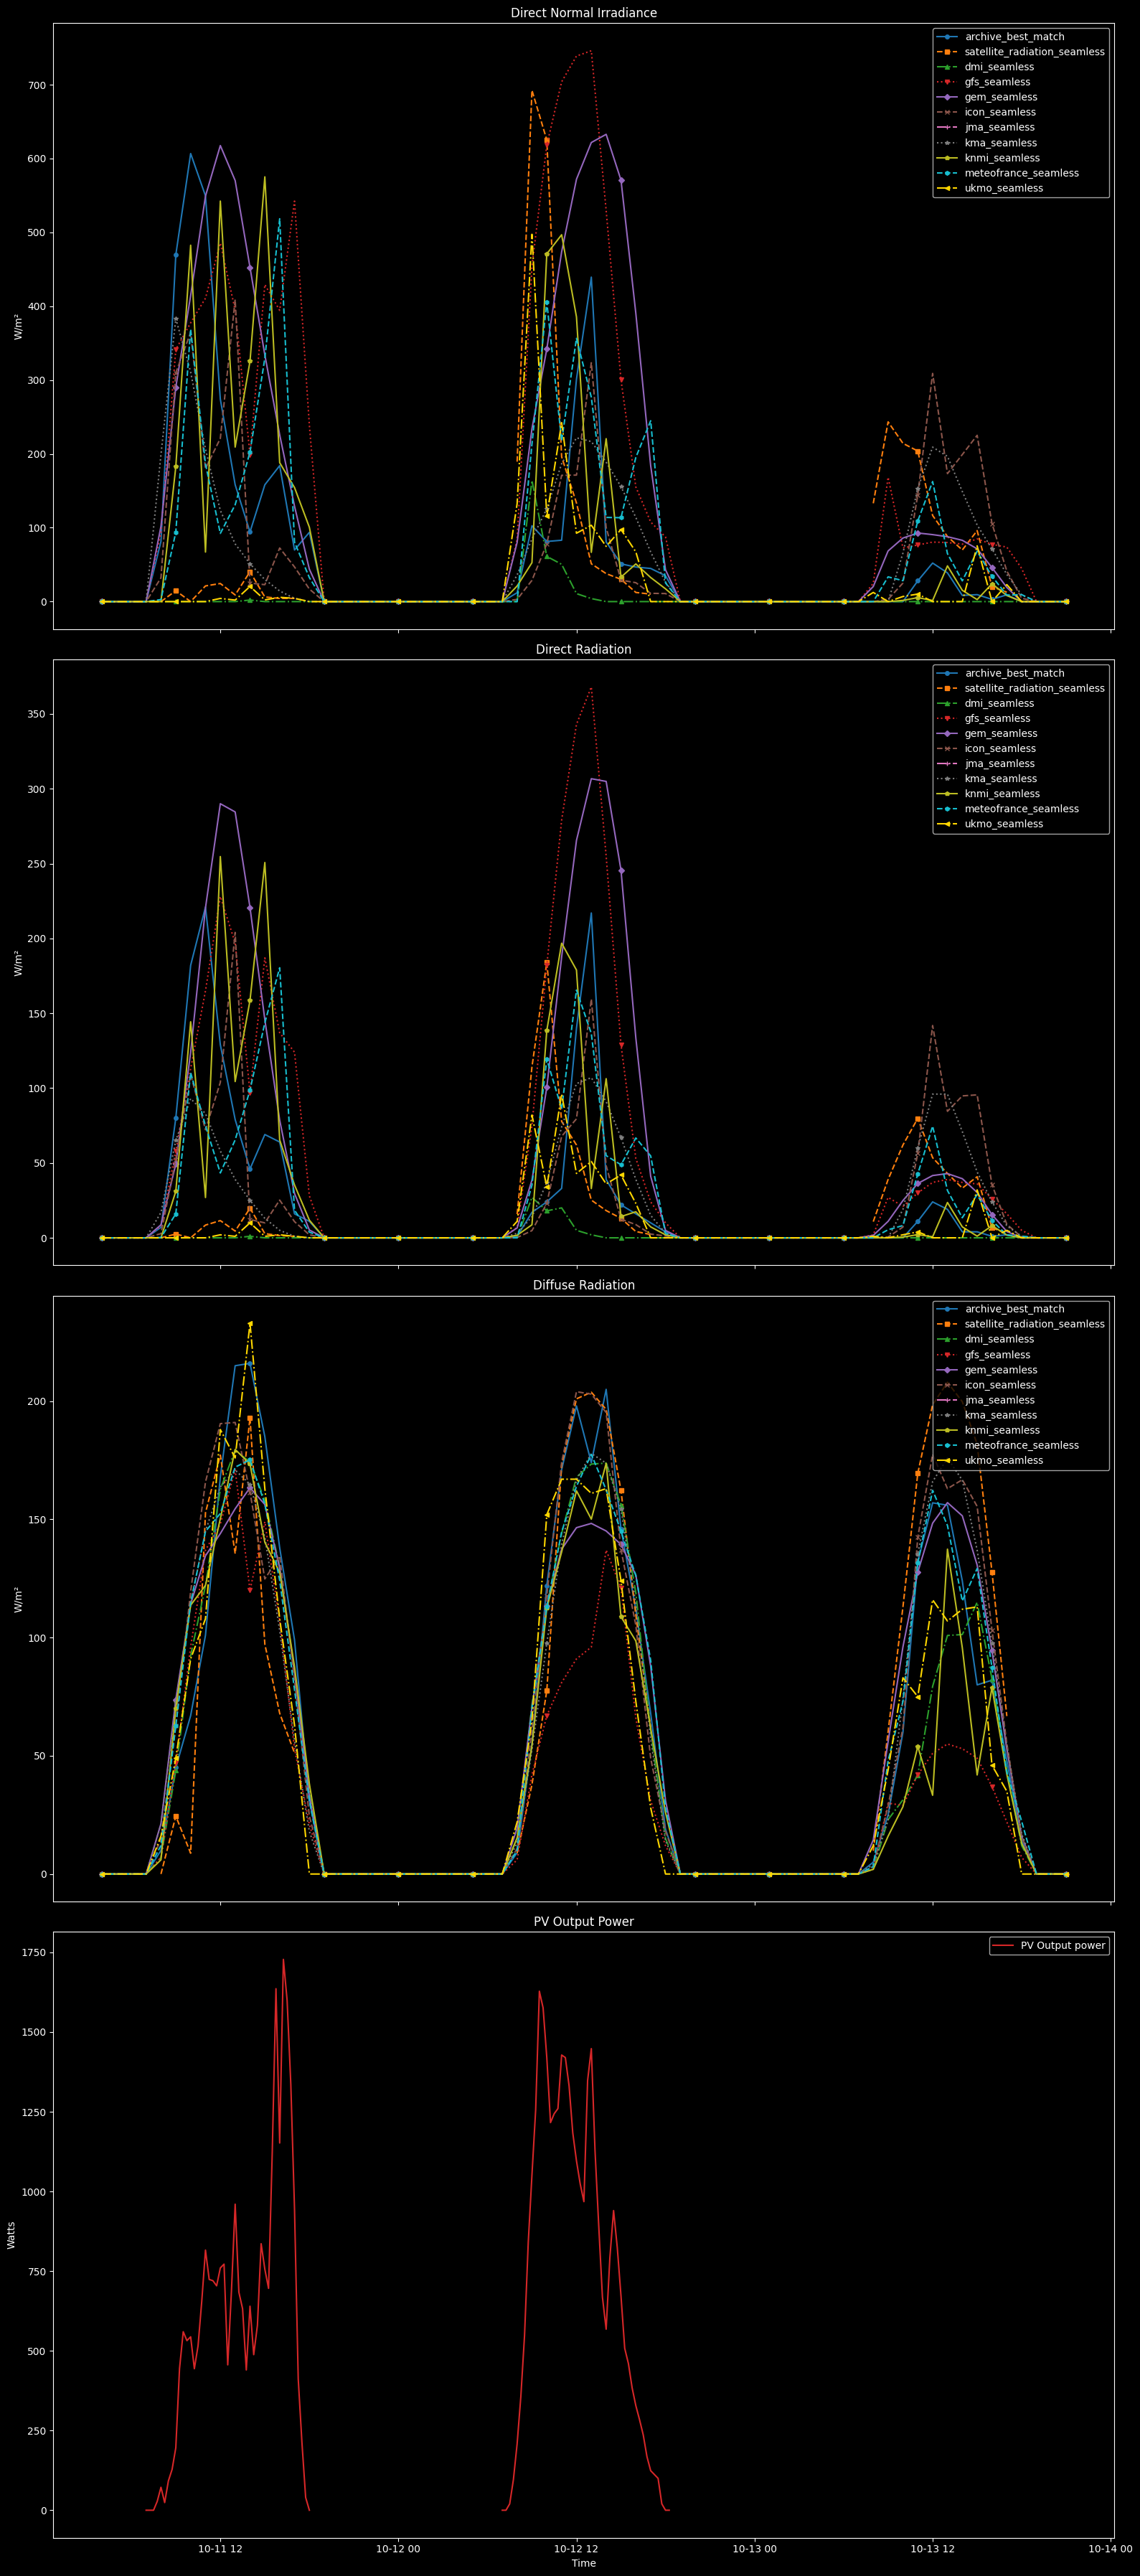

In [88]:

start = pd.Timestamp('2025-10-11 04:00:00')
end = pd.Timestamp('2025-10-13 22:00:00')

om_hourly_slice = om_hourly[(om_hourly['time'] >= start) & (om_hourly['time'] < end)]
pvo_slice = pvo_slice[(pvo_slice['time'] >= start) & (pvo_slice['time'] < end)]

fig, axes = plt.subplots(4, 1, figsize=(16, 36), sharex=True)

models = [
    'archive_best_match',
    'satellite_radiation_seamless',
    'dmi_seamless',
    'gfs_seamless',
    'gem_seamless',
    'icon_seamless',
    'jma_seamless',
    'kma_seamless',
    'knmi_seamless',
    'meteofrance_seamless',
    'meteoswiss_icon_seamless',
    'metno_seamless,era5_seamless',
    'ukmo_seamless',
]

om_hourly_slice.info()

# Define distinct visual styles for each model
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan',
          'gold', 'lime', 'navy']
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'v', 'D', 'x', '+', '*', 'p', 'h', '<', '>', 'd']

def plot_satellite_model(ax: plt.Axes, title: str, field_prefix: str):
    model_idx = 0
    for model in models:
        field = f'{field_prefix}_{model}'
        if field in om_hourly_slice.columns:
            color = colors[model_idx % len(colors)]
            linestyle = line_styles[model_idx % len(line_styles)]
            marker = markers[model_idx % len(markers)]

            ax.plot(om_hourly_slice['time'], om_hourly_slice[field],
                   label=model, color=color, linestyle=linestyle,
                   marker=marker, markevery=5, markersize=4)
            model_idx += 1
    ax.set_title(title)
    ax.set_ylabel('W/m²')
    ax.legend()

plot_satellite_model(axes[0], 'Direct Normal Irradiance', 'direct_normal_irradiance')
plot_satellite_model(axes[1], 'Direct Radiation', 'direct_radiation')
plot_satellite_model(axes[2], 'Diffuse Radiation', 'diffuse_radiation')

# 6. PV Output Power
axes[3].plot(pvo_slice['time'], pvo_slice['power'], label='PV Output power', color='tab:red', linestyle='-')
axes[3].set_title('PV Output Power')
axes[3].set_ylabel('Watts')
axes[3].legend()

axes[3].set_xlabel('Time')
plt.tight_layout()
plt.show()
